In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')


### Preprocessing

In [17]:
df = pd.read_csv("../build_dataset/output_csv/bloomberg_data.csv")
df = df.dropna(subset=['Offer To 1st Close'])
df.head(3)

,Issuer Ticker,Issuer Name,Sales - 1 Yr Growth,Profit Margin,Return on Assets,Offer Size (M),Shares Outstanding (M),Offer Price,Offer To 1st Close,Market Cap at Offer (M),...,Instit Owner (Shares Held),Filing Term Price Range,Priced Range,Industry Sector,Industry Group,Industry Subgroup,Fed Rate,CPI,Consumer Confidence,Unemployment Rate
0,0000492D US,Pioneer Municipal and Equity I,NaN,NaN,NaN,430.50,0.0000,15.0,0.000000,0.00,...,NaN,NaN,NaN,Financial,Country Funds-Closed-end,Finance-Investment Fund,0.94,0.488334,103.8,5.7
1,0000708D US,Spirit Finance Corp/Old,128.2,27.7,2.1,330.00,63.5068,11.0,12.727273,698.57,...,NaN,10.50 - 12.50,Priced Within Range,Financial,REITS,REITS-Diversified,2.04,-0.366492,97.1,5.4
2,0117799D US,Penn Virginia GP Holdings LP,31.5,4.3,2.9,127.65,39.0250,18.5,-2.702703,721.96,...,NaN,18 - 20,Priced Within Range,Energy,Coal,Coal,5.27,0.148883,91.7,4.4


In [18]:
def convert_features(df):
    """
    Convert the 'Trade Date (US)' column to separate columns for 
    month, day, and year, and drop the original 'Trade Date (US)' column.

    Also, convert Offer To 1st Close to a binary classification (Underpriced
    column) and drop original column.
    """
    df['Trade Date (US)'] = pd.to_datetime(df['Trade Date (US)'])
    df['Trade Month'] = df['Trade Date (US)'].dt.month
    df['Trade Day'] = df['Trade Date (US)'].dt.day
    df['Trade Year'] = df['Trade Date (US)'].dt.year
    df.drop(columns=['Trade Date (US)'], inplace=True)
    df['Underpriced'] = df['Offer To 1st Close'].apply(lambda x: 1 if x < 0 else 0)
    df.drop(columns=['Offer To 1st Close'], inplace=True)
    return df

df_convert_features = convert_features(df)

In [19]:
def drop_columns(columns,df):
    """
    Drop the specified columns from the DataFrame.
    """
    df = df.drop(columns=columns)
    return df

df_drop_columns = drop_columns(['Issuer Ticker',
                                'Issuer Name',
                                'Filing Term Price Range',
                                'cusip',
                                'Priced Range'],
                                df_convert_features)

In [20]:
def encoding(df):
    """
    Split the DataFrame into development and testing sets, using stratified sampling. 
    
    Fill missing values with the mode for categorical 
    columns and the mean for numerical columns.

    Encode columns in the DataFrame: 

      - Categorical columns are encoded using OneHotEncoder.
      - Numerical columns are scaled using StandardScaler.
      - Ordinal columns are encoded using OrdinalEncoder.

    Create df_dev and df_test using the transformed features.
    """

    X = df.drop(columns=['Underpriced'])
    y = df['Underpriced']

    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    for col in X_dev.columns:
        if X_dev[col].dtype == 'object':
            mode = X_dev[col].mode()[0]
            X_dev[col] = X_dev[col].fillna(mode)
            X_test[col] = X_test[col].fillna(mode)
        else:
            mean = X_dev[col].mean()
            X_dev[col] = X_dev[col].fillna(mean)
            X_test[col] = X_test[col].fillna(mean)


    oe_columns = ['Trade Month', 'Trade Day', 'Trade Year'] 
    ohe_columns = ['Industry Sector', 'Industry Group', 'Industry Subgroup']
    ss_columns = [col for col in X.select_dtypes(exclude=['object']).columns if col not in oe_columns]

    oe = OrdinalEncoder()
    ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    ss = StandardScaler()

    preprocess = ColumnTransformer(transformers=[
        ('ohe', ohe, ohe_columns),
        ('ss', ss, ss_columns),
        ('oe', oe, oe_columns)
    ], remainder='passthrough')

    transformed_dev = preprocess.fit_transform(X_dev)
    transformed_test = preprocess.transform(X_test)

    features = preprocess.get_feature_names_out()

    df_dev = pd.DataFrame(transformed_dev, columns=features)
    df_test = pd.DataFrame(transformed_test, columns=features)

    df_dev['Underpriced'] = y_dev.reset_index(drop=True)
    df_test['Underpriced'] = y_test.reset_index(drop=True)

    assert not df_dev.isnull().any().any(), "Missing values found in development set"
    assert not df_test.isnull().any().any(), "Missing values found in test set"
    assert len(df_dev.columns) == len(df_test.columns), "Mismatch in number of features"

    return df_dev, df_test

df_dev_encoding, df_test_encoding = encoding(df_drop_columns)

In [21]:
def show_feature_importances(df_dev):
    """
    Calculate feature importance using a simple model
    """
    X_dev = df_dev.drop(columns=['Underpriced'])
    y_dev = df_dev['Underpriced']
    
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_dev, y_dev)
    importances = pd.Series(rf.feature_importances_, index=X_dev.columns)
    print("\nFeature Importances:")
    print(importances.sort_values(ascending=False).head(10))

show_feature_importances(df_dev_encoding)


Feature Importances:
ss__Offer Size (M)              0.056044
ss__Offer Size (M).1            0.049801
ss__Return on Assets            0.048003
ss__Consumer Confidence         0.043566
ss__Profit Margin               0.040497
ss__Shares Outstanding (M).1    0.039922
ss__Shares Outstanding (M)      0.039793
ss__CPI                         0.039407
ss__Market Cap at Offer (M)     0.038942
ss__Fed Rate                    0.037658
dtype: float64


In [22]:
def get_correlation(df_dev, df_test, outfile):
    """
    Check correlation in the X_dev column and drop highly correlated features.
    """
    # Calculate correlation on training data only
    X_dev = df_dev.drop(columns=['Underpriced'])
    corr_matrix = X_dev.corr().abs()
    
    # Find highly correlated features
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= 0.9)]
    
    # Apply the same feature selection to both sets
    X_dev_reduced = X_dev.drop(columns=to_drop)
    X_test_reduced = df_test.drop(columns=['Underpriced']).drop(columns=to_drop)

    df_dev = pd.concat([X_dev_reduced, df_dev['Underpriced'].reset_index(drop=True)], axis=1)
    df_test = pd.concat([X_test_reduced, df_test['Underpriced'].reset_index(drop=True)], axis=1)

    print(f"Removed {len(to_drop)} correlated features.")
    df_test.to_csv(outfile, index=False)

    return df_dev, df_test

df_dev_correlation, df_test_correlation = get_correlation(df_dev_encoding, df_test_encoding, './output_csv/Final_Output_Class_test.csv')

Removed 29 correlated features.


Underpriced
0    2532
1     614
Name: count, dtype: int64

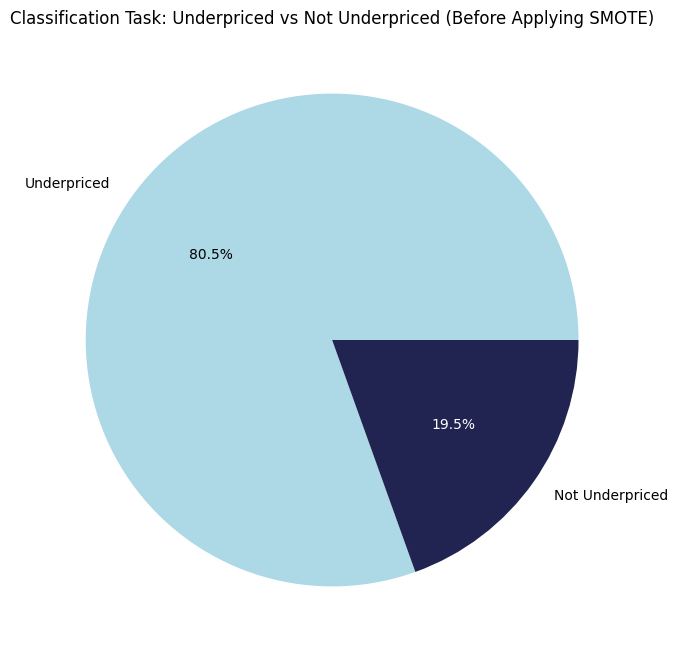

In [23]:
def display_distribution(df_dev_correlation):
    """
    Displaying pie plot to show target data imbalance.
    """
    df = df_dev_correlation.copy()
    plt.figure(figsize=(8, 8))
    underpriced_counts = df['Underpriced'].value_counts()
    display(underpriced_counts)
    labels = ['Underpriced', 'Not Underpriced']
    colors = ['lightblue', '#212351']

    wedges, texts, autotexts = plt.pie(
        underpriced_counts, labels=labels, colors=colors,
        autopct='%1.1f%%', textprops={'color': 'black'}
    )

    for i, autotext in enumerate(autotexts):
        if colors[i] == '#212351':
            autotext.set_color('white')

    plt.title('Classification Task: Underpriced vs Not Underpriced (Before Applying SMOTE)')
    plt.show()
    
display_distribution(df_dev_correlation)

In [24]:
def checkimbalance(df, outfile):
    """
    Checking imbalance in the target data. 

    If imbalance, resample using SMOTE.
    """
    X_dev = df.drop(columns=['Underpriced'])
    y_dev = df['Underpriced']

    label_count_norm = df['Underpriced'].value_counts(normalize=True)
    label_count = df['Underpriced'].value_counts()
    print(f"Class distribution (normalized):\n{label_count_norm}\n")
    print(f"Class distribution:\n{label_count}\n")


    imbalance = abs(label_count_norm[0] - 0.5) > 0.1

    if imbalance:
        print('The data is imbalanced. Applying SMOTE...')
        sampler = SMOTE(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X_dev, y_dev)
        df_final = pd.concat([X_resampled, y_resampled], axis=1)
        df_final.to_csv(outfile, index=False)
        print(f'The initial dataset had {y_dev.shape[0]} rows')
        print(f'The resampled dataset has {y_resampled.shape[0]} rows')
        print(f'Resampled feature matrix shape: {X_resampled.shape}')
        return df_final
    else:
        print('The data is balanced. No resampling applied.')
        return df
    
df_dev_resampled = checkimbalance(df_dev_correlation, './output_csv/Final_Output_Class_dev.csv')

Class distribution (normalized):
Underpriced
0    0.804832
1    0.195168
Name: proportion, dtype: float64

Class distribution:
Underpriced
0    2532
1     614
Name: count, dtype: int64

The data is imbalanced. Applying SMOTE...
The initial dataset had 3146 rows
The resampled dataset has 5064 rows
Resampled feature matrix shape: (5064, 387)


### Model Training

In [25]:
def split_data(df, target_col='Underpriced'):
    """Preprocess the data with feature engineering and scaling"""
    X = df.drop(columns=target_col)
    y = df[target_col]
    return X, y

In [26]:
def get_enhanced_model_params():
    """Return enhanced classification models with wider search space"""
    return {
        "Logistic Regression": {
            "model": LogisticRegression(solver='liblinear', random_state=42),
            "params": {
                "C": [0.01, 0.1, 1, 10, 100]
            }
        },
        "Ridge Classifier": {
            "model": RidgeClassifier(),
            "params": {
                "alpha": [0.1, 1.0, 10.0]
            }
        },
        "Support Vector Classifier": {
            "model": SVC(probability=True, random_state=42),
            "params": {
                "kernel": ["rbf", "poly"],
                "C": [0.1, 1, 10],
                "gamma": ["scale", "auto"]
            }
        },
        "LightGBM Classifier": {
            "model": LGBMClassifier(random_state=42, n_jobs=-1),
            "params": {
                "n_estimators": [100, 200, 500],
                "learning_rate": [0.001, 0.01, 0.1],
                "max_depth": [3, 5, 7, -1],
                "num_leaves": [15, 31, 63],
                "subsample": [0.8, 0.9, 1.0],
                "verbosity": [-1]
            }
        },
        "Random Forest Classifier": {
            "model": RandomForestClassifier(random_state=42, n_jobs=-1),
            "params": {
                "n_estimators": [100, 200],
                "max_depth": [None, 10, 20],
                "max_features": ["sqrt", "log2"]
            }
        },
        "K-Nearest Neighbors": {
            "model": KNeighborsClassifier(),
            "params": {
                "n_neighbors": [3, 5, 7],
                "weights": ["uniform", "distance"]
            }
        }
    }



In [27]:
def evaluate_models(model_params, X_train, y_train, X_val, y_val):
    """Evaluate classification models with multiple metrics"""
    results = []

    total_models = len(model_params)
    print(f"Evaluating {total_models} models...\n")

    for i, (name, mp) in enumerate(model_params.items(), 1):
        print(f"[{i}/{total_models}] Training and evaluating: {name}...", end=" ")

        try:
            if mp["params"]:
                grid = GridSearchCV(
                    mp["model"], 
                    mp["params"], 
                    cv=5, 
                    scoring='f1', 
                    n_jobs=-1,
                    verbose=0
                )
                grid.fit(X_train, y_train)
                best_model = grid.best_estimator_
                print("✓ (GridSearch complete)")
            else:
                best_model = mp["model"]
                best_model.fit(X_train, y_train)
                print("✓ (No tuning needed)")
            
            # Cross-validation scores
            cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1')
            
            y_pred = best_model.predict(X_val)
            acc = accuracy_score(y_val, y_pred)
            f1 = f1_score(y_val, y_pred, zero_division=0)
            precision = precision_score(y_val, y_pred, zero_division=0)
            recall = recall_score(y_val, y_pred, zero_division=0)
            
            results.append({
                "Model": name,
                "Accuracy": acc,
                "F1 Score": f1,
                "Precision": precision,
                "Recall": recall,
                "CV F1 Mean": cv_scores.mean(),
                "CV F1 Std": cv_scores.std()
            })
            
            # Plot learning curves
            train_sizes, train_scores, val_scores = learning_curve(
                best_model, X_train, y_train, cv=5, scoring='f1',
                train_sizes=np.linspace(0.1, 1.0, 10)
            )
            
            plt.figure(figsize=(10, 6))
            plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
            plt.plot(train_sizes, val_scores.mean(axis=1), label='Cross-validation score')
            plt.fill_between(train_sizes, 
                           train_scores.mean(axis=1) - train_scores.std(axis=1),
                           train_scores.mean(axis=1) + train_scores.std(axis=1),
                           alpha=0.1)
            plt.fill_between(train_sizes,
                           val_scores.mean(axis=1) - val_scores.std(axis=1),
                           val_scores.mean(axis=1) + val_scores.std(axis=1),
                           alpha=0.1)
            plt.title(f'Learning Curves - {name}')
            plt.xlabel('Training examples')
            plt.ylabel('F1 Score')
            plt.legend()
            plt.grid(True)
            plt.show()
            
            # Plot feature importance for tree-based models
            if hasattr(best_model, 'feature_importances_'):
                importances = best_model.feature_importances_
                indices = np.argsort(importances)[::-1]
                plt.figure(figsize=(10, 6))
                plt.title(f'Feature Importances - {name}')
                plt.bar(range(X_train.shape[1]), importances[indices])
                plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
                plt.tight_layout()
                plt.show()
                
        except Exception as e:
            print(f"✗ Error with {name}: {str(e)}")
            continue
    
    results_df = pd.DataFrame(results)
    top5_models_df = results_df.sort_values(by="F1 Score", ascending=False).head(5).reset_index(drop=True)
    
    return results_df, top5_models_df

In [28]:
def clean_column_names(df):
    df.columns = df.columns.str.replace(r"[^\w\d_]+", "_", regex=True)
    return df

In [29]:
def main():
    try:
        df_dev = pd.read_csv('./output_csv/Final_Output_Class_dev.csv')
        X, y = split_data(df_dev)
        X = clean_column_names(X)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        
        model_params = get_enhanced_model_params()
        results_df, top5_models_df = evaluate_models(model_params, X_train, y_train, X_val, y_val)
        
        print("\nTop 5 Models:")
        print(top5_models_df)
        
        results_df.to_csv('./output_csv/classification_results.csv', index=False)
        top5_models_df.to_csv('./output_csv/top5_classification_models.csv', index=False)
        
    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        raise

Evaluating 6 models...

[1/6] Training and evaluating: Logistic Regression... ✓ (GridSearch complete)


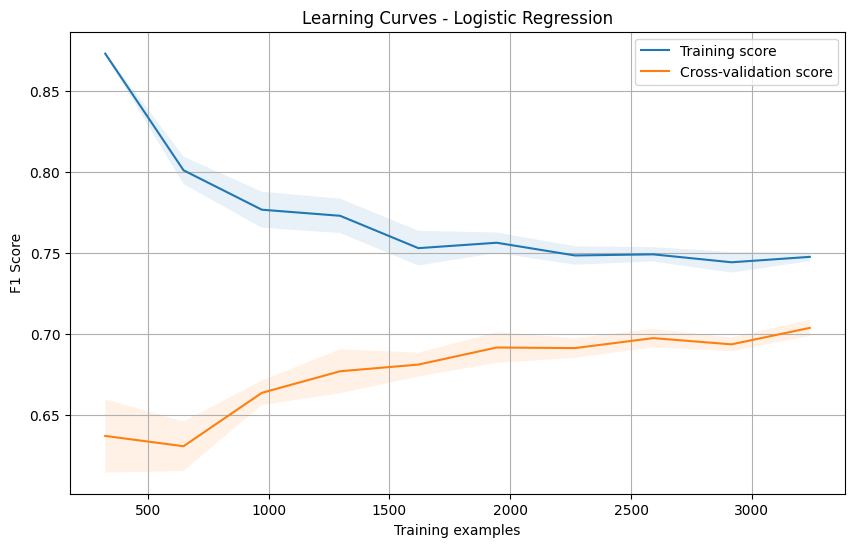

[2/6] Training and evaluating: Ridge Classifier... ✓ (GridSearch complete)


KeyboardInterrupt: 

In [30]:
main()